# Project: Housing Evictions and Fair Market Rents in New York City

## Table of Contents 

<div class = "alert alert-info">
    
1. [Introduction](#intro)<br>
2. [Research question](#question)<br>
    2.1 [Assumptions](#assumptions)<br>
3. [Data](#data)<br>
    3.1 [Univariate analysis](#univariate)<br>
    3.2 [Geospatial analysis](#geospatial)<br>
4. [Data analysis](#analysis)<br>
    4.1 [Bivariate Analysis](#bivariate)<br>
    4.2 [Multivariate Analysis](#multivariate)<br>
5. [Conclusions](#conclusions)<br>
6. [References](#references)<br>
    
</div>

## Introduction <a id='intro'></a>
In the wake of the COVID-19 pandemic, New Yorkers have feared a rise in housing evictions across the city as landlords attempt to recover their losses and forcibly evict tenants.  As housing courts have reopened and the eviction deferment period is long passed, we are now seeing a rise in evictions across the city.  According to a New York _Times_ [article](https://www.nytimes.com/2022/05/02/nyregion/new-york-evictions-cases.html), the housing chaos began this spring:

> "The roughly 2,000 eviction cases filed by landlords every week since March are roughly 40 percent more than the number filed in mid-January [2022], after the state’s eviction moratorium expired. Tenants have been thrown out of homes in more than 500 cases since February, according to city data, about double the number in all of the 20 months prior." (Zaveri, 2022)

In this project we will attempt to test the relationship of housing evictions to a variety of neighborhood demographics including changes in the fair market housing rates (FMR) through exploratory data analysis (EDA) using data selected from [BetaNYC](https://data.beta.nyc), the [United States Department of Housing and Urban Development](https://www.huduser.gov), and [Eviction Lab](https://evictionlab.org/):

* [BetaNYC](https://data.beta.nyc/en/dataset/pediacities-nyc-neighborhoods/resource/7caac650-d082-4aea-9f9b-3681d568e8a5)
* [Crosswalk (HUD)](https://www.huduser.gov/portal/datasets/usps_crosswalk.html)
* [Eviction Lab](https://evictionlab.org/)
* [Fair market housing rates (HUD)](https://www.huduser.gov/portal/datasets/fmr.html)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path

# Constants
GRAY = "#44475a"
CYAN = "#8be9fd"
RED = "#ff5555"

# Fall back to GitHub because __file__ isn't defined for Notebooks and cwd is flawed
try:
    eviction = pd.read_parquet(Path.cwd().parent.joinpath(
        "assets/data/evict_merged.parquet"))
except FileNotFoundError:
    eviction = pd.read_parquet(
        "https://raw.githubusercontent.com/amelia-ingram/eviction-rent/main/assets/data/evict_merged.parquet")

# Rate of evictions per population per neighborhood per 100 people
eviction["evic_per_100"] = (eviction.filings_2020 / eviction.population) * 100


(Temp)

In [23]:
# Temp to keep myself organized
eviction.head()

,city,type,geoid,racial_majority,month,filings_2020,filings_avg,fmr_2br,fmr_2br_90,fmr_2br_110,borough,post_office,neighborhood,population,density,evic_per_100
0,"New York, NY",Zip Code,10001.0,White,2020-01-01,51,55.000000,2110.0,1899.0,2321.0,Manhattan,"New York, NY",Chelsea and Clinton,21102.0,33959.0,0.241683
1,"New York, NY",Zip Code,10001.0,White,2020-02-01,23,49.333333,2110.0,1899.0,2321.0,Manhattan,"New York, NY",Chelsea and Clinton,21102.0,33959.0,0.108994
2,"New York, NY",Zip Code,10001.0,White,2020-03-01,20,48.333333,2110.0,1899.0,2321.0,Manhattan,"New York, NY",Chelsea and Clinton,21102.0,33959.0,0.094778
3,"New York, NY",Zip Code,10001.0,White,2020-04-01,0,41.666667,2110.0,1899.0,2321.0,Manhattan,"New York, NY",Chelsea and Clinton,21102.0,33959.0,0.000000
4,"New York, NY",Zip Code,10001.0,White,2020-05-01,0,42.000000,2110.0,1899.0,2321.0,Manhattan,"New York, NY",Chelsea and Clinton,21102.0,33959.0,0.000000


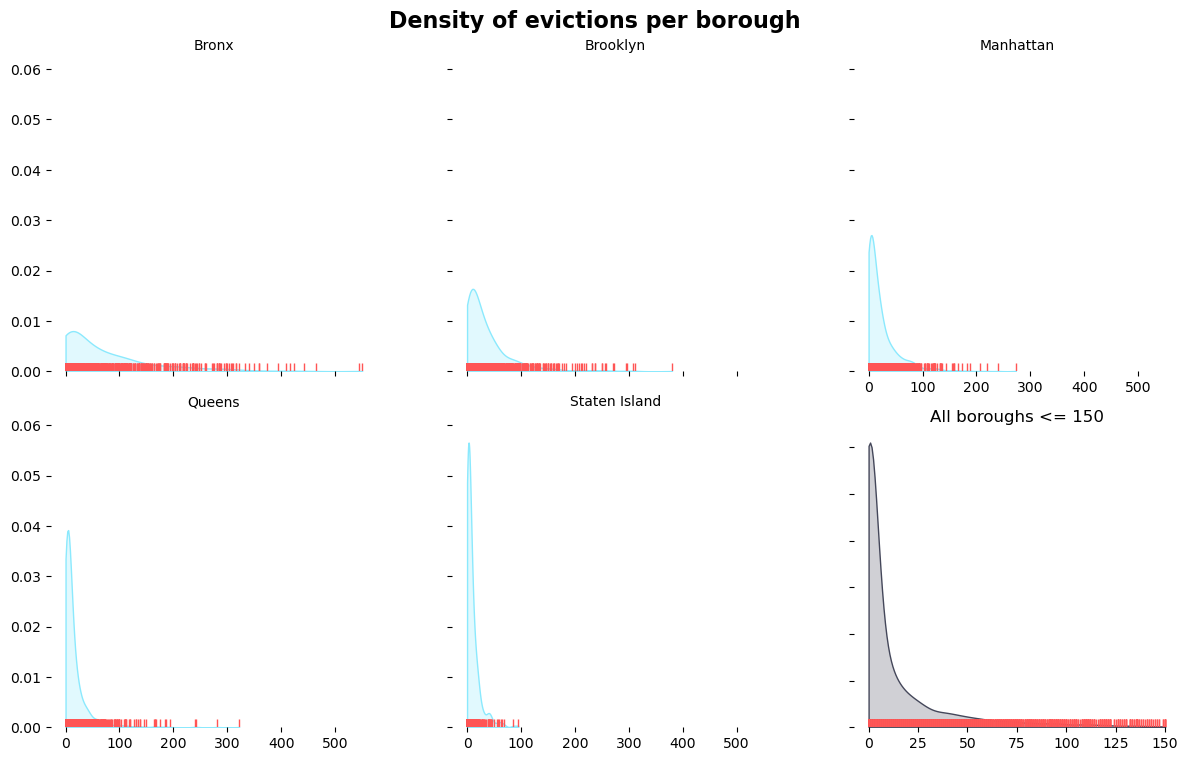

In [20]:
def kde_filings(x, kde_color=CYAN, rug_color=RED, **kwargs):
    """Convenience function to plot a KDE + rug.

    x: pd.Series
        Values to plot.
    kde_color: str
        Color for filled KDE.
    rug_color: str
        Color for rug plot.
    **kwargs: dict[str, Any]
        Keyword arguments to pass down to both plots.
    """
    # Color is passed in through map, but it needs to be suppressed or else two "color" are passed in.
    kwargs.pop("color", None)

    sns.kdeplot(x=x, cut=0, bw_method="scott",
                color=kde_color, fill=True, **kwargs)
    sns.rugplot(x=x, color=rug_color, **kwargs)


# Facet plot with data sorted on borough (alphabetize plot)
kde_facet = sns.FacetGrid(eviction.sort_values(
    "borough"), col="borough", col_wrap=3, height=4, despine=True)
kde_facet.map(kde_filings, "filings_2020")

# Add an extra plot for the total clipped density
kde_total = kde_facet.figure.add_subplot(2, 3, 6)
kde_filings(eviction.filings_2020[eviction.filings_2020 <= 150], kde_color=GRAY,
            ax=kde_total)

# Aesthetics
kde_facet.set_axis_labels("", "")
kde_facet.set_titles("{col_name}")
kde_facet.despine()
kde_facet.figure.suptitle(
    "Density of evictions per borough", y=0.97, fontsize=16, fontweight="bold")

# The frame doesn't really add much
for ax in kde_facet.axes:
    ax.set_frame_on(False)

kde_facet.tight_layout()

# Aesthetics for the clipped total density
kde_total.set_title("All boroughs <= 150", y=0.95)
kde_total.set_xlabel("")
kde_total.set_ylabel("")
kde_total.set_frame_on(False)
_ = kde_total.set_yticklabels("")


Blah blah

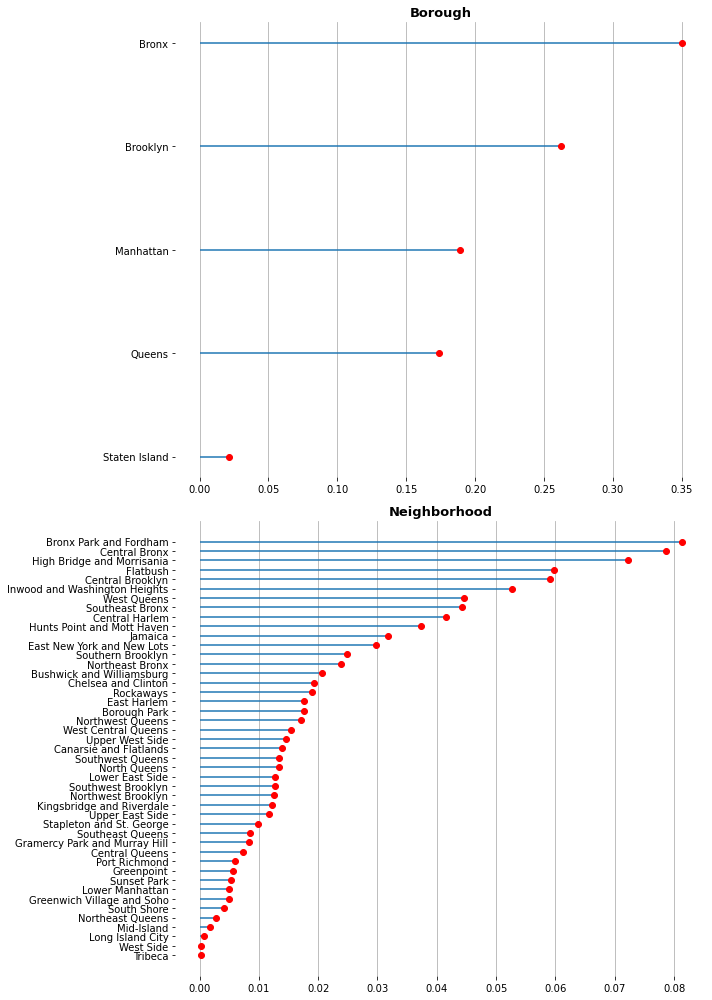

In [12]:
fig_lollypop, axes_lollypop = plt.subplots(2, figsize=(10, 14))

for ax, variable in zip(axes_lollypop, ["borough", "neighborhood"]):
    # Proportion of evictions per variable as a whole
    var_groupby = eviction[[variable, "filings_2020"]].groupby(variable).agg(
        lambda col_group: col_group.sum()/eviction.filings_2020.sum())
    var_groupby.sort_values("filings_2020", inplace=True)

    # Horizontal lines for the sticks and dots for the lolly pops.
    ax.hlines(var_groupby.index, xmin=0, xmax=var_groupby)
    ax.plot(var_groupby, var_groupby.index, "or")

    # Aesthetics
    ax.set_title(variable.title(), {"size": 13, "weight": "bold"})
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    ax.set_frame_on(False)

fig_lollypop.set_tight_layout(True)